In [ ]:
# Importing all Library
import os
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader,random_split
import random
from torchvision import transforms

In [ ]:
# Image Dataset Path

image_data_path = 'T:\DL Project\Data'

In [ ]:
# This is used to transform the image data into tensors. The dimensions for each image is 128*128.

transform = transforms.Compose([transforms.Resize((128,128)),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.38, 0.38, 0.38], [0.38, 0.38, 0.38])])
image_dataset = torchvision.datasets.ImageFolder(root=image_data_path,transform=transform)

In [ ]:
# Dividing the dataset into Validation , Test and Train sizes

validation_data_size = int((10 * len(image_dataset))/100)
test_data_size = int((10 * len(image_dataset))/100)
train_data_size = len(image_dataset)- (validation_data_size+test_data_size)
print("The Validation Dataset Size : ",validation_data_size)
print("The Test Dataset Size : ", test_data_size)
print("The Train Dataset Size : ",train_data_size)

The Validation Dataset Size :  2755
The Test Dataset Size :  2755
The Train Dataset Size :  22048


In [ ]:
# changing device to GPU for faster processing

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dt,device):
        self.dt = dt
        self.device = device
    def __iter__(self):
        for d in self.dt:
            yield to_device(d, self.device)
    def __len__(self):
        return len(self.dt)

In [ ]:
# Checking device to understand whether it is CPU or GPU

if torch.cuda.is_available():
    device= torch.device('cuda')
else:
    device= torch.device('cpu')
print(device)

cpu


In [ ]:
batch_size=128
train_data, validation_data ,test_data = random_split(image_dataset, [train_data_size, validation_data_size,test_data_size])
train_data_loader = DataLoader(train_data, batch_size, shuffle=True)
val_data_loader = DataLoader(validation_data, batch_size,shuffle=True)

# Visualizing 5 Random Images From both classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

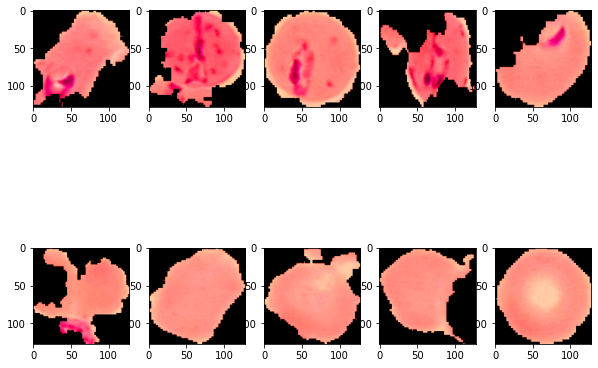

In [ ]:
def imshow(img,k,j):
    img = img.numpy()
    img_t = np.transpose(img, (1,2,0))
    axis[k][j].imshow(img_t)

fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(10,8))
k=0
for img in range(5):
    imshow(image_dataset[int(random.random()*100)][0],k,img)
k+=1
for img in range(5):
    imshow(image_dataset[int(random.random()*100+len(image_dataset)/2+1)][0],k,img)
k += 1
plt.show()

In [ ]:
def accuracy(outputs, labels):
    _,preds=torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [ ]:
# Plotting functions for loss
def train_validation_loss(history):
    training_loss= [x.get('train_loss') for x in history]
    validation_loss = [x['val_loss'] for x in history]
    plt.plot(training_loss, '-bx')
    plt.plot(validation_loss, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. of epochs')

In [ ]:
class CNN(nn.Module):
    def __init__(self,weight_init='he_weights'):
        super().__init__()

        def random_weights(m):
          if isinstance(m,nn.Linear):
            torch.nn.init.normal_(m.weight)
            torch.nn.init.normal_(m.bias)

        def zeros_weights(m):
          if isinstance(m,nn.Linear):
            torch.nn.init.zeros_(m.weight)
            torch.nn.init.zeros_(m.bias)

        def he_weights(m):
           torch.nn.init.kaiming_normal_(m.weight)
           torch.nn.init.kaiming_normal_(m.bias)
        
        self.network = nn.Sequential(

            #Block A
            nn.Conv2d(3, 16, kernel_size=9,stride=1,padding=3),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #Block B
            nn.Conv2d(16, 32, kernel_size=6,stride=1,padding=3),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #Block C
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.Dropout(p=0.4),
            nn.Flatten(),
            nn.Linear(32*32*64, 2),
            nn.Dropout(p=0.4),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)

    def l1_regularisation(self,x):
      return torch.abs(x).sum()

    def l2_regularisation(self,x):
      return torch.square(x).sum()

In [ ]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs=[]
    for batch in val_loader:
        images, targets = batch
        out = model(images)
        loss = F.cross_entropy(out, targets)
        score = accuracy(out, targets)
        outputs.append({'val_loss': loss.detach(), 'val_score': score })
        #outputs.append(model.validation_step(batch))
    batch_losses = [l['val_loss'] for l in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_scores = [s['val_score'] for s in outputs]
    epoch_score = torch.stack(batch_scores).mean()
    return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}

def training(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD,regularization='l1'):

    # releasing unoccupied cached memory
    torch.cuda.empty_cache()

    training_history = []

    optimizer = opt_func(model.parameters(),lr) 

    for epoch in range(epochs):
        model.train()
        training_losses = []
        for batch in tqdm(train_loader):

            # Training Step

            images, targets = batch
            out = model(images)
            loss = F.cross_entropy(out, targets)
            #loss = model.training_step(batch)


            #checking for regularization

            if regularization=="l1":
              l1_w=0.0001
              model_parameters=[]
              for i in model.parameters():
                model_parameters.append(i.view(-1))
              l1=l1_w * model.l1_regularisation(torch.cat(model_parameters))
              loss+=l1

            if regularization=="l2":
              l2_w=0.0001
              model_parameters=[]
              for i in model.parameters():
                model_parameters.append(i.view(-1))
              l2=l2_w * model.l2_regularisation(torch.cat(model_parameters))
              loss+=l2

            training_losses.append(loss)

            # Back Propagation

            loss.backward()
            optimizer.step()

            # resetting the gradient after each batch

            optimizer.zero_grad()

        # Evaluating the validation set

        result=evaluate(model,val_loader)
        result['train_loss'] = torch.stack(training_losses).mean().item()
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_score']))
        training_history.append(result)

    return training_history

# Model with random weights initialization

In [ ]:
model_random = to_device(CNN('random_weights'), device)
train_device_loader=DeviceDataLoader(train_data_loader,device)
val_device_loader=DeviceDataLoader(val_data_loader,device)
print(model_random)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
num_epochs=5
optimizer_function=torch.optim.Adam
learning_rate=0.001
history_random=training(num_epochs,learning_rate,model_random,train_device_loader,val_device_loader,optimizer_function,"")

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.69, val_loss: 0.69, val_score: 0.50


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.69, val_loss: 0.69, val_score: 0.50


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.69, val_loss: 0.69, val_score: 0.50


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.69, val_loss: 0.69, val_score: 0.51


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.69, val_loss: 0.69, val_score: 0.51


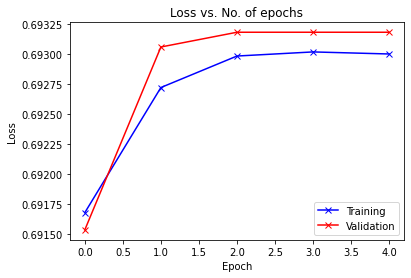

In [ ]:
train_validation_loss(history_random)

In [ ]:
evaluate(model_random,val_data_loader)

{'val_loss': 0.6931828856468201, 'val_score': 0.5042772889137268}

In [ ]:
#storing the torch model
torch.save(model_random.state_dict(), os.path.join(image_data_path, "model_random.pth"))

In [ ]:
#loading the model
model_random_load=CNN()
model_random_load.load_state_dict(torch.load(os.path.join(image_data_path, "model_random.pth")))
model_random_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
evaluate(model_random_load,val_data_loader)

{'val_loss': 0.6931828856468201, 'val_score': 0.5046005845069885}

# Model with He weight Initialization

In [ ]:
model_he = to_device(CNN('he_weights'), device)
print(model_he)
train_device_loader=DeviceDataLoader(train_data_loader,device)
val_device_loader=DeviceDataLoader(val_data_loader,device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
num_epochs=5
opt_func=torch.optim.Adam
lr=0.001
history_he=training(num_epochs,lr,model_he,train_device_loader,val_device_loader,opt_func,"")

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.7757, val_loss: 0.6922, val_score: 0.5040


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6932, val_loss: 0.6930, val_score: 0.5049


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6932, val_loss: 0.6930, val_score: 0.5049


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6932, val_loss: 0.6930, val_score: 0.5027


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6932, val_loss: 0.6930, val_score: 0.5046


In [ ]:
evaluate(model_he,val_data_loader)

{'val_loss': 0.6930122971534729, 'val_score': 0.5058938264846802}

In [ ]:
#storing the torch model
torch.save(model_he.state_dict(), os.path.join(image_data_path, "model_he.pth"))

In [ ]:
#loading the model
model_he_load=CNN()
model_he_load.load_state_dict(torch.load(os.path.join(image_data_path, "model_he.pth")))
model_he_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Sigmoid()
  )
)

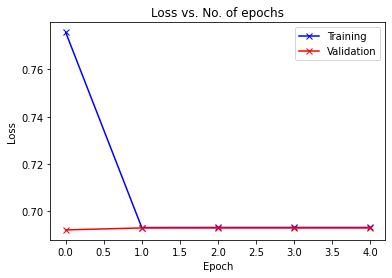

In [ ]:
train_validation_loss(history_he)

In [ ]:
evaluate(model_he_load,val_data_loader)

{'val_loss': 0.8166723251342773, 'val_score': 0.4967244863510132}

# Model with zero weight initialization

In [ ]:
model_zeros = to_device(CNN('zeros_weights'), device)
print(model_zeros)
train_device_loader=DeviceDataLoader(train_data_loader,device)
val_device_loader=DeviceDataLoader(val_data_loader,device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
history_zeros=training(num_epochs,lr,model_zeros,train_device_loader,val_device_loader,opt_func,"")

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.81, val_loss: 0.81, val_score: 0.51


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.81, val_loss: 0.81, val_score: 0.50


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.81, val_loss: 0.81, val_score: 0.51


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.81, val_loss: 0.81, val_score: 0.50


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.81, val_loss: 0.81, val_score: 0.50


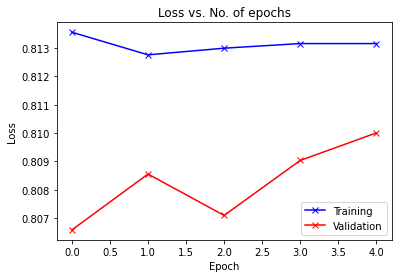

In [ ]:
train_validation_loss(history_zeros)

In [ ]:
evaluate(model_zeros,val_data_loader)

{'val_loss': 0.8096808791160583, 'val_score': 0.5036306381225586}

In [ ]:
#storing the torch model
torch.save(model_zeros.state_dict(), os.path.join(image_data_path, "model_zeros.pth"))

In [ ]:
#loading the model
model_zeros_load=CNN()
model_zeros_load.load_state_dict(torch.load(os.path.join(image_data_path, "model_zeros.pth")))
model_zeros_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
evaluate(model_zeros_load,val_data_loader)

{'val_loss': 0.8077409267425537, 'val_score': 0.5055704712867737}

# Model with dropout after convolution




In [ ]:
model_dropout1= to_device(CNN('he_weights'), device)
print(model_dropout1)
train_device_loader=DeviceDataLoader(train_data_loader,device)
val_device_loader=DeviceDataLoader(val_data_loader,device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.4, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=2, bias=True)
    (8): Sigmoid()
  )
)


In [ ]:
history_dropout1=training(num_epochs,lr,model_dropout1,train_device_loader,val_device_loader,opt_func,"")

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.7098, val_loss: 0.6853, val_score: 0.5030


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.6882, val_loss: 0.6914, val_score: 0.5046


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6910, val_loss: 0.6913, val_score: 0.5036


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.6893, val_loss: 0.7341, val_score: 0.5254


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8117, val_loss: 0.8094, val_score: 0.5039


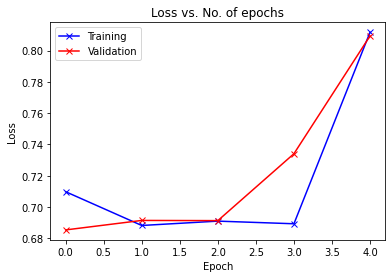

In [ ]:
train_validation_loss(history_dropout1)

In [ ]:
evaluate(model_dropout1,val_data_loader)

{'val_loss': 0.8097086548805237, 'val_score': 0.5035670399665833}

In [ ]:
torch.save(model_dropout1.state_dict(), os.path.join(image_data_path, "model_dropout1.pth"))
model_dropout1_load=CNN()
model_dropout1_load.load_state_dict(torch.load(os.path.join(image_data_path, "model_dropout1.pth")))
model_dropout1_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.4, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=2, bias=True)
    (8): Sigmoid()
  )
)

In [ ]:
evaluate(model_dropout1_load,val_data_loader)

{'val_loss': 0.8090620636940002, 'val_score': 0.5042136907577515}

# Model with dropout between fully connected layers

In [ ]:
model_dropout2= to_device(CNN('he_weights'), device)
print(model_dropout2)
train_device_loader=DeviceDataLoader(train_data_loader,device)
val_device_loader=DeviceDataLoader(val_data_loader,device)
history_dropout2=training(num_epochs,lr,model_dropout2,train_device_loader,val_device_loader,opt_func,"")

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Sigmoid()
  )
)


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.7511, val_loss: 0.8093, val_score: 0.5039


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7524, val_loss: 0.8080, val_score: 0.5052


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7517, val_loss: 0.8126, val_score: 0.5007


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7491, val_loss: 0.8093, val_score: 0.5039


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7524, val_loss: 0.8087, val_score: 0.5046


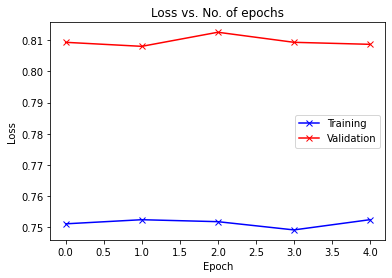

In [ ]:
train_validation_loss(history_dropout2)

In [ ]:
evaluate(model_dropout2,val_data_loader)

{'val_loss': 0.8119261264801025, 'val_score': 0.5013356804847717}

In [ ]:
torch.save(model_dropout2.state_dict(), os.path.join(image_data_path, "model_dropout2.pth"))

model_dropout2_load=CNN()
model_dropout2_load.load_state_dict(torch.load(os.path.join(image_data_path, "model_dropout2.pth")))
model_dropout2_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Sigmoid()
  )
)

In [ ]:
evaluate(model_dropout2,val_data_loader)

{'val_loss': 0.8093397617340088, 'val_score': 0.503922164440155}

# Model with L1 Regularization

In [ ]:
model_L1= to_device(CNN('he_weights'), device)
print(model_L1)
train_device_loader=DeviceDataLoader(train_data_loader,device)
val_device_loader=DeviceDataLoader(val_data_loader,device)
history_L1=training(num_epochs,lr,model_L1,train_device_loader,val_device_loader,opt_func,"l1")

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Sigmoid()
  )
)


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.8155, val_loss: 0.6942, val_score: 0.5055


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.8254, val_loss: 0.6940, val_score: 0.5029


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7681, val_loss: 0.8128, val_score: 0.4982


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7826, val_loss: 0.6910, val_score: 0.5266


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7577, val_loss: 0.6969, val_score: 0.4984


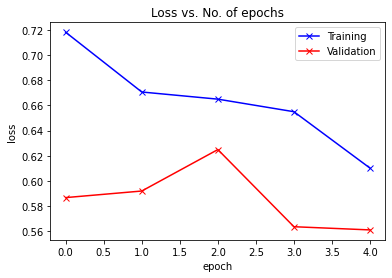

In [ ]:
train_validation_loss(history_L1)

In [ ]:
evaluate(model_L1,val_data_loader)

{'val_loss': 0.6968709826469421, 'val_score': 0.5016324520111084}

In [ ]:
torch.save(model_L1.state_dict(), os.path.join(image_data_path, "model_L1.pth"))
model_L1_load=CNN()
model_L1_load.load_state_dict(torch.load(os.path.join(image_data_path, "model_L1.pth")))
model_L1_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Sigmoid()
  )
)

In [ ]:
evaluate(model_L1,val_data_loader)

{'val_loss': 0.6967481970787048, 'val_score': 0.4990459680557251}

# Model with L2 Regularization

In [ ]:
model_L2= to_device(CNN('he_weights'), device)
print(model_L2)
train_device_loader=DeviceDataLoader(train_data_loader,device)
val_device_loader=DeviceDataLoader(val_data_loader,device)
history_L2=training(num_epochs,lr,model_L1,train_device_loader,val_device_loader,opt_func,"l2")

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Sigmoid()
  )
)


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.7476, val_loss: 0.7114, val_score: 0.4908


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7300, val_loss: 0.8103, val_score: 0.5035


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7569, val_loss: 0.8086, val_score: 0.5049


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7579, val_loss: 0.8100, val_score: 0.5036


  0%|          | 0/173 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7563, val_loss: 0.8090, val_score: 0.5045


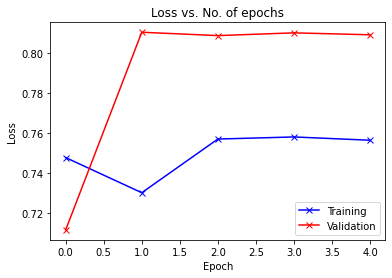

In [ ]:
train_validation_loss(history_L2)

In [ ]:
evaluate(model_L2,val_data_loader)

{'val_loss': 0.693155825138092, 'val_score': 0.5131868720054626}

In [ ]:
torch.save(model_L2.state_dict(), os.path.join(image_data_path, "model_L2.pth"))
model_L2_load=CNN()
model_L2_load.load_state_dict(torch.load(os.path.join(image_data_path, "model_L2.pth")))
model_L2_load.eval()

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=65536, out_features=2, bias=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Sigmoid()
  )
)

In [ ]:
evaluate(model_L2,val_data_loader)

{'val_loss': 0.6931466460227966, 'val_score': 0.5144801735877991}